In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,Conv1D,Input,Flatten
from tensorflow.keras.layers import MaxPooling1D, Flatten, Bidirectional, TimeDistributed, RepeatVector
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import concatenate
# from tensorflow.keras.utils.vis_utils import plot_model
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import re
import string
import pickle
import random
import tensorflow as tf
import datetime
from sklearn.preprocessing import StandardScaler

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(470528, 9)


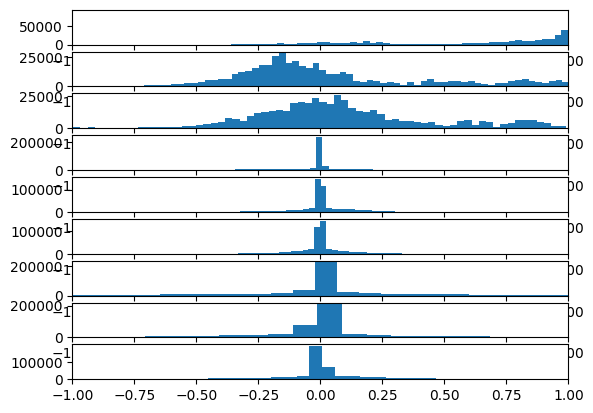

In [28]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, delim_whitespace=True, header=None)
    return dataframe.values

def load_group(filename,prefix=''):
    loaded = list()
    for name in filename:
        # print(name)
        data_load = load_file(prefix + name)
        loaded.append(data_load)
    loaded = np.dstack(loaded)
    return loaded

def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filename = list()
    filename += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filename += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filename += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filename, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

def load_dataset(prefix=''):
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    print(trainX.shape, trainy.shape)
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    print(testX.shape, testy.shape)    
    # zero-offset class values
    # start 0->5
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy
def plot_variable_distributions(trainX):
    cut = int(trainX.shape[1]/2)
    longX = trainX[:,-cut:,:]
    longX = longX.reshape((longX.shape[0]*longX.shape[1], longX.shape[2]))
    print(longX.shape)
    plt.figure()
    xaxis = None
    for i in range(longX.shape[1]):
        ax = plt.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
        ax.set_xlim(-1, 1)
        if i == 0:
            xaxis = ax
        plt.hist(longX[:, i], bins=100)
    plt.show()

trainX, trainy, testX, testy = load_dataset()
plot_variable_distributions(trainX)

def scale_data(trainX,testX,standardize):
    cut = int(trainX.shape[1]/2)
    longX = trainX[:,-cut:,:]
    longX = longX.reshape((longX.shape[0]*longX.shape[1], longX.shape[2]))

    flatTrainX = trainX.reshape((trainX.shape[0]*trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0]*testX.shape[1], testX.shape[2]))
    if standardize:
        s =  StandardScaler()
        s.fit(longX)
        longX = s.transform(longX)
        flatTrainX = s.transform(flatTrainX)
        flatTestX = s.transform(flatTestX)
        
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX,flatTestX

In [29]:
def evaluate_model(trainX, trainy, testX, testy,param,n_filters):
    verbose, epochs, batch_size = 1, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # trainX, testX = scale_data(trainX,testX,param)
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX,trainy, epochs=epochs, batch_size=batch_size, verbose=verbose),
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

def evaluate_model1(trainX, trainy, testX, testy,param,n_filters):
    verbose, epochs, batch_size = 1, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # trainX, testX = scale_data(trainX,testX,param)
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=n_filters,kernel_size=3,activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=n_filters,kernel_size=5,activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=n_filters,kernel_size=7,activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    from keras.utils import plot_model
    time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    plot_model(model, to_file=f'model-{time}.png',show_shapes=True)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit([trainX,trainX,trainX],trainy, epochs=epochs, batch_size=batch_size, verbose=verbose),
    # evaluate model
    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    return accuracy
    
def summarize_result(scores,params):
    print(scores,params)
    for i in range(len(scores)):
        m,s = np.mean(scores[i]), np.std(scores[i])
        print('Param %d: %.3f%% (+/-%.3f)' % (params[i],m,s))
    plt.boxplot(scores,labels=params)
    time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    plt.savefig(f'exp_cnn_{time}.png')

def summarize_result(scores,params,n_filters):
    print(scores,params)
    for p in range(len(params)):
        for fil in range(len(n_filters)):
            # for i in range(len(scores)):
            m,s = np.mean(scores[p][fil]), np.std(scores[p][fil])
            print('Param #%d - fil #%d: %.3f%% (+/-%.3f)' % (params[p],n_filters[fil],m,s))
        plt.boxplot(scores[p],labels=n_filters)
        time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        plt.savefig(f'exp_cnn_param-{p}_{time}.png')
        plt.close()


def run_experiment(params,n_filters,repeats=10):
    # load data
    trainX,trainy,testX,testy = load_dataset()
    # repeat experiment
    all_scores = list()
    for p in params:
        all_scores_notp = list()
        for fil in n_filters:
            scores = list()
            for r in range(repeats):
                score = evaluate_model1(trainX, trainy, testX, testy, p, fil)
                score = score * 100.0
                print('>p=%s #%d #%d: %.3f' % (p,fil,r+1,score))
                scores.append(score)
            all_scores_notp.append(scores)
        all_scores.append(all_scores_notp)
        # summarize results
    summarize_result(all_scores,params,n_filters)

n_filters =[128]
# nonlocal_params = [True,False]
nonlocal_params = [False]
run_experiment(nonlocal_params,n_filters)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
Epoch 1/10
230/230 [==============================] - 4s 14ms/step - loss: 0.3400 - accuracy: 0.8739
Epoch 2/10
230/230 [==============================] - 3s 12ms/step - loss: 0.1276 - accuracy: 0.9476
Epoch 3/10
230/230 [==============================] - 3s 12ms/step - loss: 0.1112 - accuracy: 0.9539
Epoch 4/10
230/230 [==============================] - 3s 12ms/step - loss: 0.1057 - accuracy: 0.9509
Epoch 5/10
230/230 [==============================] - 3s 13ms/step - loss: 0.1200 - accuracy: 0.9518
Epoch 6/10
230/230 [==============================] - 3s 12ms/step - loss: 0.1101 - accuracy: 0.9523
Epoch 7/10
230/230 [==============================] - 3s 12ms/step - loss: 0.0984 - accuracy: 0.9565
Epoch 8/10
230/230 [==============================] - 3s 13ms/step - loss: 0.0911 - accuracy: 0.9580
Epoch 9/10
230/230 [==============================] - 3s 12ms/step - loss: 0.0850 - accuracy: 0.9599
Epoch 10/10
230/230 [====================